<a href="https://colab.research.google.com/github/mgmeti/language-model-course/blob/main/Copy_of_Solution_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Recurrent Neural Networks 


In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Dense
from sklearn.preprocessing import LabelEncoder

In [2]:
!gdown https://drive.google.com/file/d/1jFFnJCr1qRHdZ4CcVg0WhmdU0EQUgtS_/view?usp=share_link --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1jFFnJCr1qRHdZ4CcVg0WhmdU0EQUgtS_
To: /content/ner_dataset.csv
100% 15.2M/15.2M [00:00<00:00, 51.8MB/s]


Assuming that the file was downloaded in the same folder as this ntoebook, the dataset can be loaded as:

In [3]:
df = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape', usecols=['Sentence #','Word','Tag'])

<div class='exercise'><b>Ex 1: Load the data </b></div></br>

The dataset contains all the sentences, with each word tagged. </br>
The tags can be:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

Note that words that are not named entities as labelled as O

Extract each sentence and transform it into an adequate format.  You can use **df.fillna(method='ffill', inplace=True)** to fill the NaN values and extract the values easily.</br>


In [4]:
# We fill Nan values using the previous value. 
# This way we can separate each sentence.
df.fillna(method='ffill', inplace=True)

# Remove "Sentence: " from the sentence column
df['Sentence #'] = df['Sentence #'].str.replace('Sentence: ','').astype(int)

# Set the index as the sentence number. Then we filter each sentence, joininig the text
df.set_index('Sentence #', inplace=True)

# Take a quick look at the dataset
df.head()

,Word,Tag
Sentence #,,
1,Thousands,O
1,of,O
1,demonstrators,O
1,have,O
1,marched,O


In [5]:
# Filter the dataframe by sequence length
# As you can see from the head above, the index values are repeated hence we need to know all the unique indices in our dataframe.
# Each unique index represents a sentence number.
# We also want to find the length of each sentence in the dataframe hence we make use of the unique function.
index, length = np.unique(df.index, return_counts=True)


# To avoid using long sentences, we are restricting length between 15 to 30 words
b1 = length>15
b2 = length<30

# We are using logical_and function because lets say if a sentence's length is greater than 15 and also greater than 30, we won't consider that sentence.
# For a sentence to be considered , both conditions must be true.
b = np.logical_and(b1, b2)

# Taking sentences satisfying the condition.
index = index[b]
length = length[b]


# Constucting a dataframe out of valid sentences.
df = df.loc[index]

In [6]:
# Helper code for train-test split
index = np.unique(df.index)

# Splitting sentences into training and test sets using index values.
# We are using random_state for reproducibility
train_index, val_index = train_test_split(index, train_size=0.8,random_state=0)

df_train = df.loc[train_index]
df_val = df.loc[val_index]

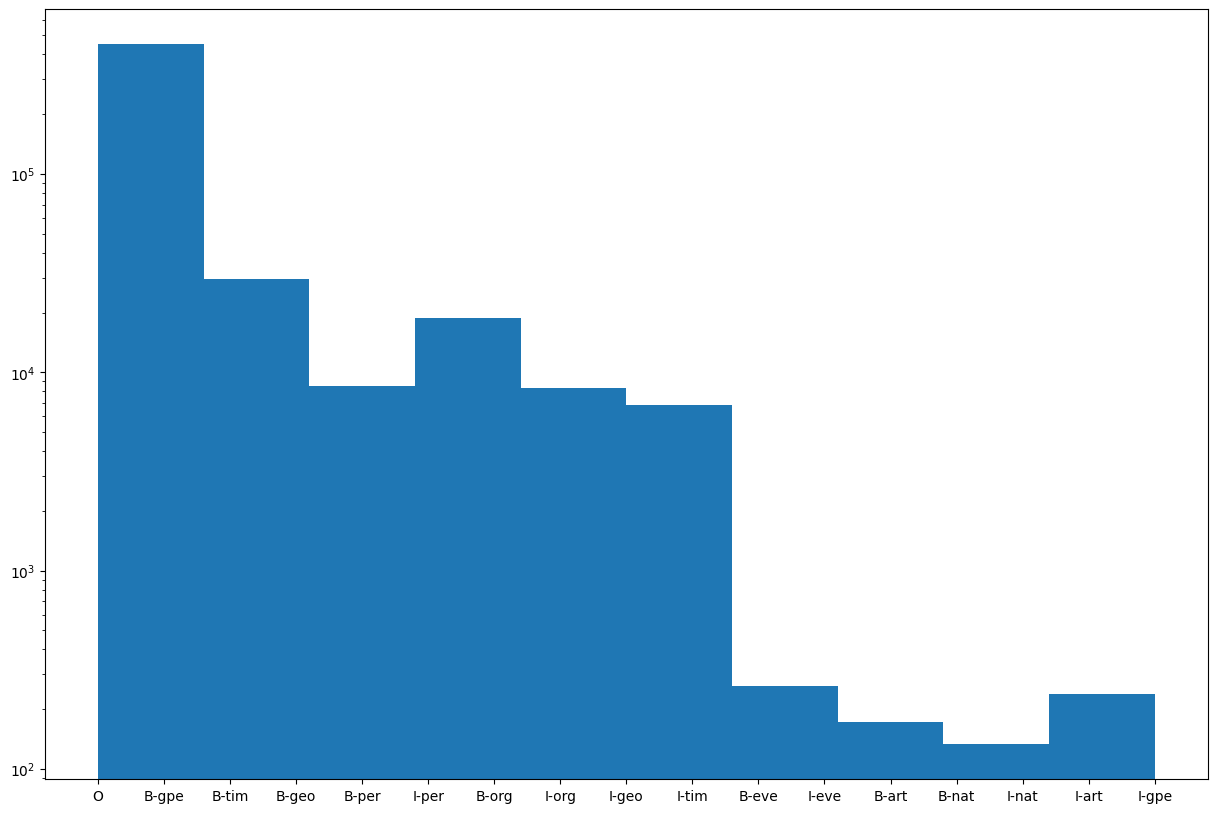

In [7]:
# Take a quick look at the different tags

plt.figure(figsize=(15,10))
plt.hist(df_train.Tag, log=True)
plt.show()

<div class='exercise'><b>Ex 2: Transform the input </b></div></br>

* We know that words need to be transformed into numerical form. Transform the _tags_ and words into numbers. </br>

* The tags can be one-hot encoded or label encoded. Altough there is no inherent order among the tags, we will use **label encoding** for simplicity. </br>

    *  The loss function to be used after label encoding is **sparse_categorical_crossentropy** </br>

* Remove alphanumeric characters from Word column in both train and validation set and replace them with empty string.

* Since Word column must also be converted to numerical values, use **tf.keras.preprocessing.text.Tokenizer** with default parameters and tokenize it.

* After tokenization of word column in  both train and validation set, remove empty elements from the tokens created and also remove sentences at those positions from dataset. This must be done for train and validation data.

* df_train.head() should look as shown below.

In [8]:
# Your code here

# Transform the tags into labels using LabelEnconder
le = LabelEncoder()
df_train['Tag'] = le.fit_transform(df_train.Tag)
df_val['Tag'] = le.transform(df_val.Tag)



# Remove characters
df_train.Word = df_train.Word.str.replace("[^a-zA-Z0-9 ]",'')
df_val.Word = df_val.Word.str.replace("[^a-zA-Z0-9 ]",'')

# Tokenize the words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=None,
                                                filters='\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                lower=True,
                                                split=' ',) # Initialize

tokenizer.fit_on_texts(df_train.Word.values) # Fit on training data

# Transform to numeric
tokens_train = tokenizer.texts_to_sequences(df_train.Word.values)
tokens_val   = tokenizer.texts_to_sequences(df_val.Word.values)

# Remove empty elements
b = np.array([token!=[] for token in tokens_train])
df_train = df_train.iloc[b,:]
tokens_train = np.array(tokens_train)[b]

b = np.array([token!=[] for token in tokens_val])
df_val = df_val.iloc[b,:]
tokens_val = np.array(tokens_val)[b]

df_train.Word = tokens_train
df_val.Word = tokens_val


df_train.Word=df_train.Word.map(lambda x: x[0])
df_val.Word=  df_val.Word.map(lambda x: x[0])

<ipython-input-8-8e796ae6f08e>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.Word = df_train.Word.str.replace("[^a-zA-Z0-9 ]",'')
<ipython-input-8-8e796ae6f08e>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_val.Word = df_val.Word.str.replace("[^a-zA-Z0-9 ]",'')
<ipython-input-8-8e796ae6f08e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tokens_train = np.array(tokens_train)[b]
<ipython-input-8-8e796ae6f08e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' 

In [9]:
# Your df_train should look like this
df_train.head()

,Word,Tag
Sentence #,,
9750,1,16
9750,147,16
9750,2322,16
9750,3605,16
9750,2486,16


We will now create our training and validation data that will be used by language models which we will be creating further. Follow the steps below for creating both training and validation data for modelling.

* Extract sentences from the dataframe created above i.e sentence 1 will be created by words at index 1 in the dataframe created above. Tags corresonding to the sentence must also be extracted along with the length of the sentence. Separate lists must be created to store sentences, tags, length of sentences.

* Omit any sentence which only has a single element.

* For simplicity, we will keep only those sentences which have length greater than 15 and less than 30 digits. Keep tags and lengths of only those sentences which satify this condition.

* We will be padding our sentences and tags using tf.keras.utils.pad_sequences() using post padding.

* Check your output with the outputs given below.

Your training and validation data should look like this.

In [10]:
# Your code here

# We create the training set structure
IDs_train = df_train.index.unique()

train_sentences = []
train_tags = []
train_Ns = []
for i in IDs_train: # For each id
    sel = df_train.loc[i] # We extract the respective data
    if len(sel.shape)<2: # If the data is not formatted properly
        continue # Ommit that id
        
    sentence = sel.Word.values # A sentence is a list of tokens
    tag = sel['Tag'].values # The tags correspond to each token
    
    train_sentences.append(sentence)  # We store the sentences in a list
    train_tags.append(tag)            # We do the same with the tags
    train_Ns.append(sentence.shape[0])# And store the length of the sentence
    
# We transform everything into np arrays    
train_Ns = np.array(train_Ns)
train_sentences = np.array(train_sentences)
train_tags = np.array(train_tags)    

# To speed up calculations, we filter by sequence length
# We do not care much of long sentences.
b1 = train_Ns>15
b2 = train_Ns<30
b = np.logical_and(b1, b2)

# We filter the training set
train_Ns = train_Ns[b]
train_sentences = train_sentences[b]
train_tags = train_tags[b]

# For simplicity, we create a padded array beforehand
train_sentences = tf.keras.utils.pad_sequences(train_sentences, padding='post')
train_tags = tf.keras.utils.pad_sequences(train_tags, padding='post')

<ipython-input-10-637b955c0468>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_sentences = np.array(train_sentences)
<ipython-input-10-637b955c0468>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_tags = np.array(train_tags)


In [11]:
# We create the training set structure
IDs_val = df_val.index.unique()

val_sentences = []
val_tags = []
val_Ns = []
for i in IDs_val: # For each id
    sel = df_val.loc[i] # We extract the respective data
    if len(sel.shape)<2: # If the data is not formatted properly
        continue # Ommit that id
        
    sentence = sel.Word.values # A sentence is a list of tokens
    tag = sel['Tag'].values # The tags correspond to each token
    
    val_sentences.append(sentence)  # We store the sentences in a list
    val_tags.append(tag)            # We do the same with the tags
    val_Ns.append(sentence.shape[0])# And store the length of the sentence
    
# We transform everything into np arrays    
val_Ns = np.array(val_Ns)
val_sentences = np.array(val_sentences)
val_tags = np.array(val_tags)    

# To speed up calculations, we filter by sequence length
# We do not care much of long sentences.
b1 = val_Ns>15
b2 = val_Ns<30
b = np.logical_and(b1, b2)

# We filter the training set
val_Ns = val_Ns[b]
val_sentences = val_sentences[b]
val_tags = val_tags[b]

# For simplicity, we create a padded array beforehand
val_sentences = tf.keras.utils.pad_sequences(val_sentences, padding='post')
val_tags = tf.keras.utils.pad_sequences(val_tags, padding='post')

<ipython-input-11-b62795e9ed2b>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_sentences = np.array(val_sentences)
<ipython-input-11-b62795e9ed2b>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_tags = np.array(val_tags)


In [12]:
val_tags[:2]

array([[ 2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,  7,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [13]:
val_sentences[:2]

array([[  106,   194,  1514,   141,  6457,  3232,     5,   105,   318,
            6, 15874,  4172,    13,  3421,   810,   384,   141,     3,
          211,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [   48,    28,    20,     1,   359,    18,   601,   396,    14,
           30,   287,     2,     1,    88,     3,    67,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)

In [14]:
train_tags[:2]

array([[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16,  0,  0,  0,  0,  0],
       [16,  3, 16, 16, 16, 16, 16, 16,  7, 16, 16,  2, 16, 16, 16, 16,
        16, 16, 16,  3,  6, 14, 14, 14,  0,  0,  0,  0]], dtype=int32)

In [15]:
train_sentences[:2]

array([[    1,   147,  2322,  3605,  2486,    70,     8,     1,   116,
            6,   514,    12,    26,   153,  2678, 13078,  1842,     6,
          299,     4,   789,   180,   110,     0,     0,     0,     0,
            0],
       [    1,   419,   123,    18,   286,     4,  6148,     5,  1757,
          669,     4,   501,    64,   340,    43,   445,     5,   185,
           14,   175,    97,    54,  1342,   998,     0,     0,     0,
            0]], dtype=int32)

<div class='exercise'><b>Ex 3: Create the model </b></div></br>

 For simplicity, use the Vanilla RNN cell. For each type of network, create models with values h=[8,16,32]</br></br>

a) Create a single-layer RNN network. Add models created using this network with different values of h in models_single_rnn list.</br></br>
b) Create a k-layer RNN network, where k=[2,3]. Add models created using this network for all combinations of k and h in models_deep_rnn list. </br></br>
c) Create a bidirectional single-layer RNN. Add models created using this network with different values of h in models_single_birnn list.</br></br>
d) Create a bidirectional k-layer RNN, where k=[2,3]. Add models created using this network for all combinations of k and h in models_deep_birnn list.</br>

Concatenate the hidden states of each layer in case of deep rnn networks, and perform classification. 

Each mode will be many to many.

* The first layer should be Embedding, with _mask_zero_ set to True. This will propagate the mask in the network.
* Then, a SimpleRNN layer. We set here the number of hidden units. Remember to return the sequence of hidden states.
* We will define a Dense layer, with size set as the number of classes and activation softmax. 
* Set batch size to 1024 and number of epochs to 20.
* **sparse_categorical_crossentropy** should be set as loss and use **adam** optimizer.
* metric to be used is **accuracy**

After creation and training of models, evaluate all your models by keeping below output as a reference.</br>





<div class='exercise'><b>Ex 3: RNN MODELS </b></div></br>




In [16]:
hidden_sizes = [8,16,32]
vocab_size = len(tokenizer.word_counts)

In [17]:
vocab_size

22962

In [18]:
le.classes_.shape[0]

17

In [19]:
# Create models

def make_model(hidden_size, layers, bidir = False):
    tf.keras.backend.clear_session()
    sentence_input1 = tf.keras.Input(shape=(None,), name='sentence_input')

    word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=hidden_size, 
                        name='word_embedding', mask_zero=True)
    masked_embeddinbg = word_embedding(sentence_input1)
    
    h_f = []
    h_b = []
    # First Forward RNN layer
    RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
    hf = RNN(masked_embeddinbg)
    h_f.append(hf)
    if bidir:
        RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, go_backwards=True)
        hb = RNN(masked_embeddinbg)
        h_b.append(hb)
        

    # Create forward RNNs
    for k in range(1,layers):
        RNN_f = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
        hf = RNN_f(hf)
        h_f.append(hf)

        if bidir:
            RNN_b = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, go_backwards=True)
            hb = RNN_b(hb)
            h_b.append(hb)
    
    if bidir:
        if layers==1:
            h = tf.keras.layers.concatenate([hf, hb])        
        else:
            h = tf.keras.layers.concatenate(h_f+h_b)
    else:
        if layers==1:
            h = h_f[0]
        else:
            h = tf.keras.layers.concatenate(h_f)
          
    
    dense = tf.keras.layers.Dense(le.classes_.shape[0], activation='softmax', )
    output = dense(h)

    model = tf.keras.Model(inputs=sentence_input1, outputs=output, name='_'.join([str(hidden_size), str(layers),str(bidir)]))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
    return model

    
    

In [20]:
# Create models

models_a = []
models_b = []
models_c = []
models_d = []
for h in hidden_sizes:
    print(h)
    models_a.append(make_model(h,1, bidir=False))
    
    models_b.append(make_model(h,2, bidir=False))
    models_b.append(make_model(h,3, bidir=False))
    
    models_c.append(make_model(h,1, bidir=True))
    
    models_d.append(make_model(h,2, bidir=True))
    models_d.append(make_model(h,3, bidir=True))
    

8
16
32


In [21]:
# Train all the models
histories= []
for model in models_a+models_b+models_c+models_d:
    history = model.fit(train_sentences
                        , train_tags
                        , validation_data = (val_sentences,val_tags)
                        , epochs=20
                        , batch_size=1024
                        , verbose=0)
    histories.append(history)

In [23]:
for model in models_a+models_b+models_c+models_d:
  print(model.summary())
  print(model.name,model.evaluate(val_sentences,val_tags))

Model: "8_1_False"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence_input (InputLayer)  [(None, None)]           0         
                                                                 
 word_embedding (Embedding)  (None, None, 8)           183704    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 8)           136       
                                                                 
 dense (Dense)               (None, None, 17)          153       
                                                                 
Total params: 183,993
Trainable params: 183,993
Non-trainable params: 0
_________________________________________________________________
None
161/161 [==============================] - 2s 9ms/step - loss: 0.7126 - accuracy: 0.8371
8_1_False [0.7125590443611145, 0.8370932936668396]
Model: "16_1_False"
__________________

<div class='exercise'><b>Ex 4: show your results </b></div></br>

* Show the graphs and the best architecture. </br>


Refer the cells below for reference output.


##BONUS

* Show 10 random sentences with the predicted and real tags. Are they correct?</br>

* Try your model with a couple of sentenses of your creation. Does it work?


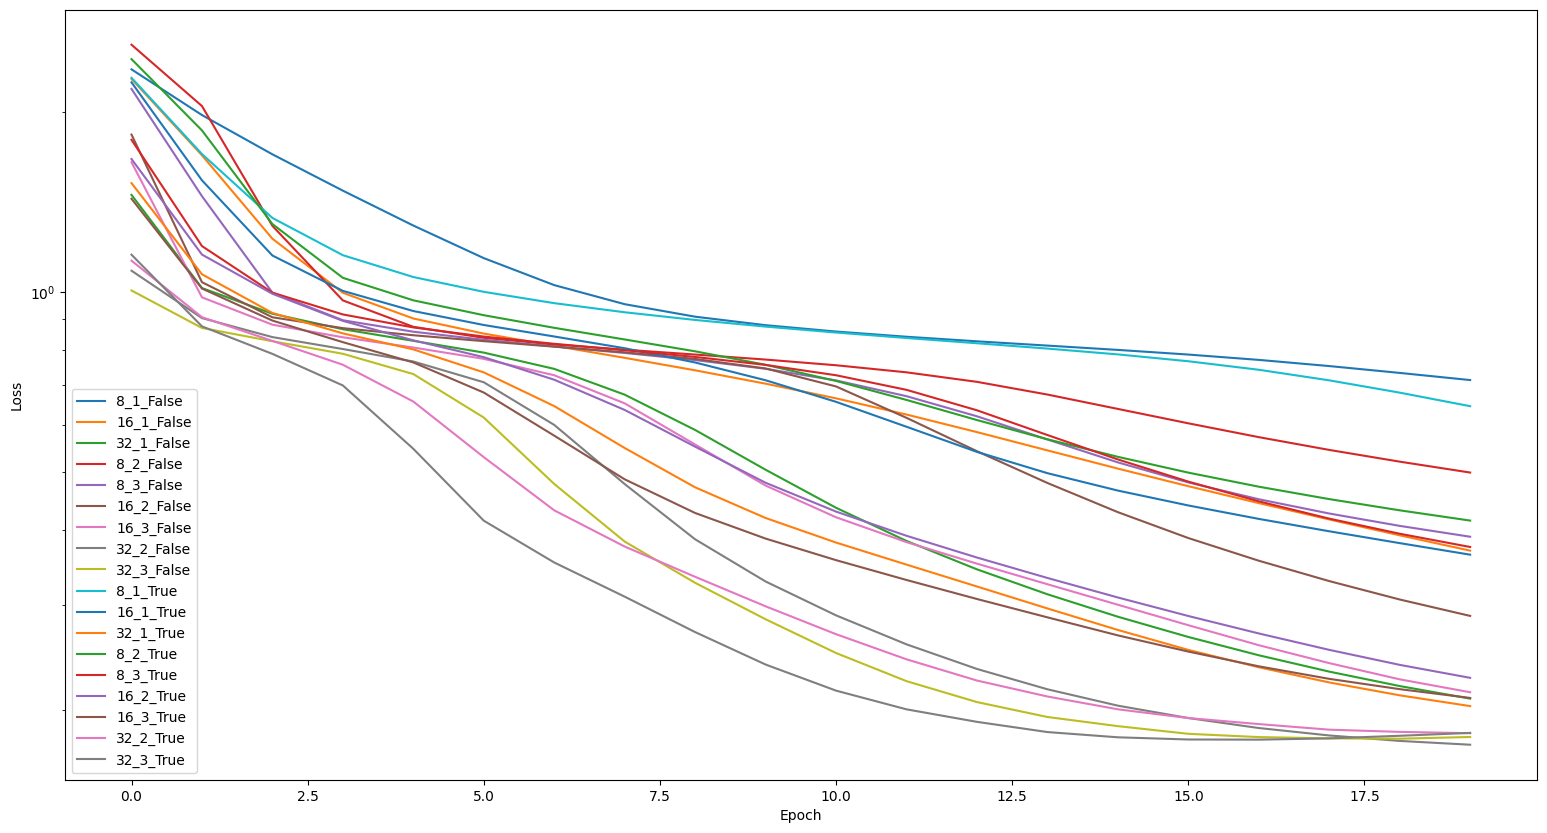

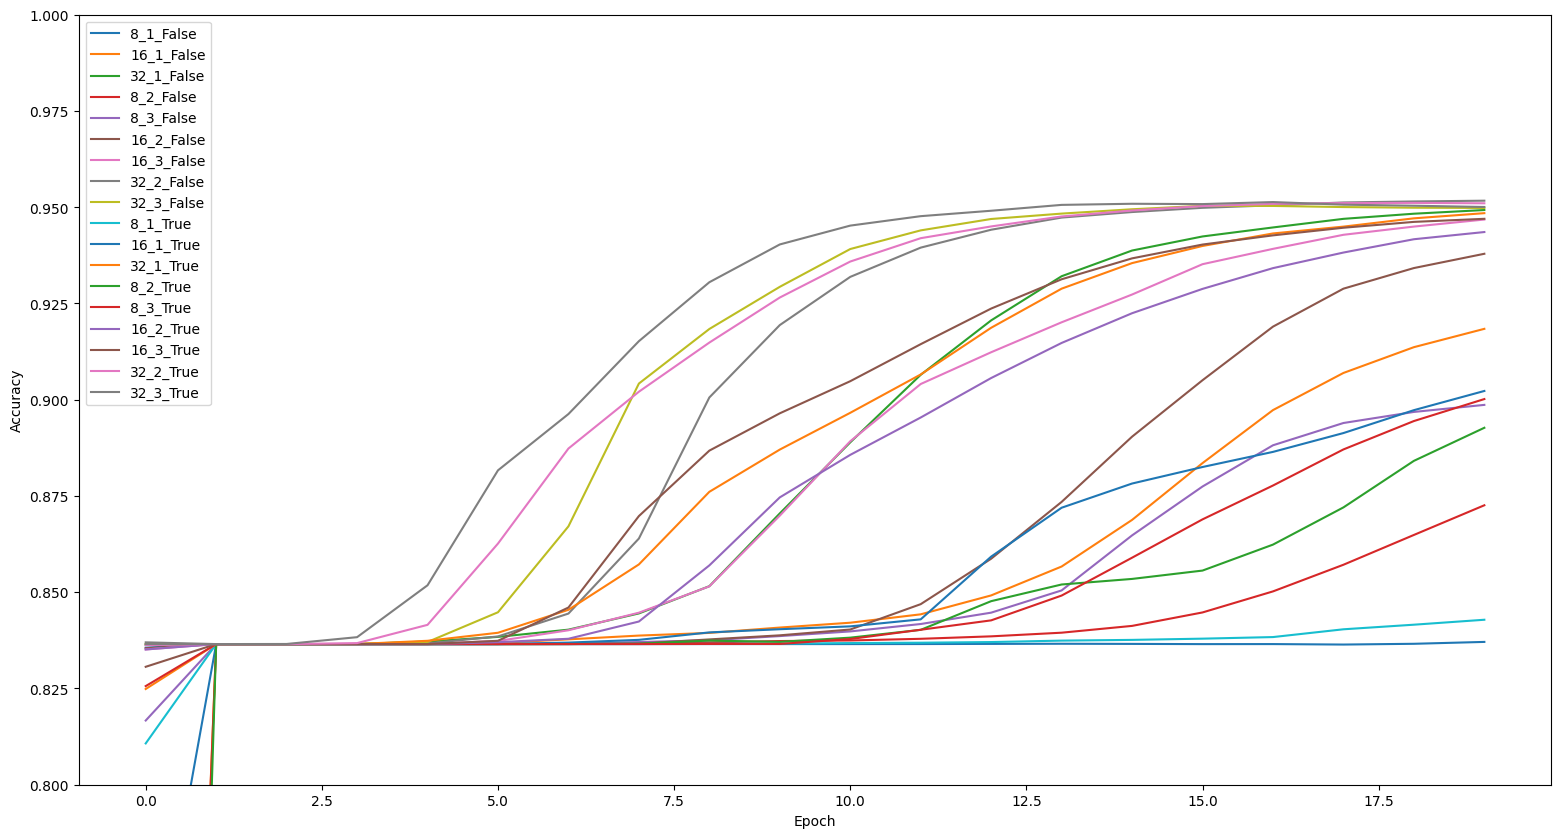

In [24]:
# Your code here


# plot the results
plt.figure(figsize=(19,10))
for history in histories:
    plt.plot(history.history['val_loss'], label=history.model.name)
plt.legend(loc=0)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(19,10))
for history in histories:
    plt.plot(history.history['val_accuracy'], label=history.model.name)
plt.legend(loc=0)
plt.ylim(0.8,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Your output should look something like the following